In [91]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
import itertools

fontsize=14

__В pdf-файле задачи 1-4__

In [374]:
from IPython.display import IFrame
IFrame("HW1_14.pdf", width=1000, height=800)

### Задача 5 

- сгенерируем s точек равномерно в квадрате стороной 2, оставим только те, для которых $|| x ||_p \le 1, p=1,2,3$
- сравним реализацию с jit и без

In [2]:
@jit(nopython=True)
def numba_unit_disk(p=1, s=100000):
    X_old, Y_old = np.random.uniform(-1.0, 1.0, s), np.random.uniform(-1.0, 1.0, s)
    X_new, Y_new = [], []
    
    for x, y in zip(X_old, Y_old):
        if (abs(x)**p + abs(y)**p)**(1/p) <= 1:
            X_new.append(x)
            Y_new.append(y)
    return X_new, Y_new

def unit_disk(p=1, s=100000):
    X_old, Y_old = np.random.uniform(-1.0, 1.0, s), np.random.uniform(-1.0, 1.0, s)
    
    X_new, Y_new = [], []
    for x, y in zip(X_old, Y_old):
        if np.linalg.norm([x, y], ord=p) <= 1:
            X_new.append(x)
            Y_new.append(y)
    return X_new, Y_new

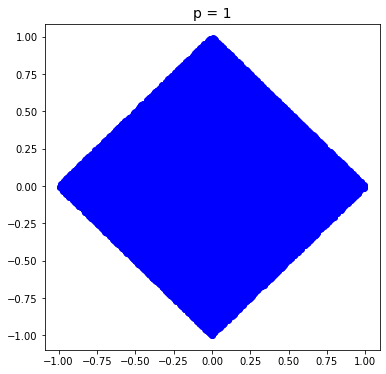

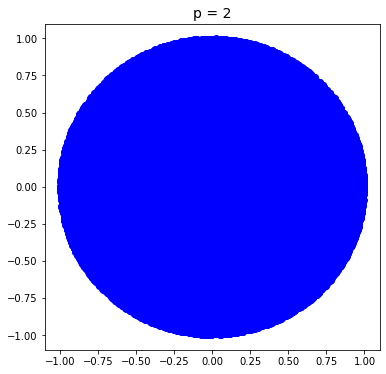

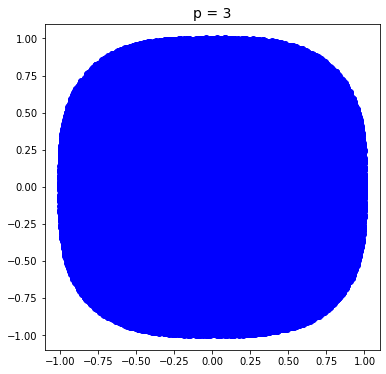

In [3]:
for n in range(1, 4):
    x, y = numba_unit_disk(n)
    
    plt.figure(figsize=(6,6))
    plt.scatter(x, y, color="blue")
    plt.title("p = {}".format(n), fontsize=fontsize)

In [4]:
%timeit unit_disk()
%timeit numba_unit_disk()

759 ms ± 74.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.3 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


__Вывод:__
- JIT крут, вычисления в 150-200 раз быстрее

### Задача 6

In [92]:
c = 3

In [93]:
# Generate some data
np.random.seed(42)
lambda1 = np.random.normal(size=(c, c))
lambda2 = np.random.normal(size=(c, c))
lambda3 = np.random.normal(size=(c, c))
G1 = np.random.normal(size=(c, c, c))
G2 = np.random.normal(size=(c, c, c))
U = np.random.normal(size=(c, c, c, c))

In [94]:
def Z_naive(lambda1, lambda2, lambda3, G1, G2, U):
    c = lambda1.shape[0]
    Z = np.zeros(shape=(c, c, c, c))
    for a, b, c, d, e, f, g, h, i, j in itertools.product(*([range(c)]*10)):
        Z[a, h, i, j] += lambda1[a, b]*lambda2[d, e]*lambda3[g, h]*G1[c, b, d]*G2[f, e, g]*U[i, j, c, f]
    return Z

def Z(lambda1, lambda2, lambda3, G1, G2, U):
    return np.einsum("ab,cbd,de,feg,gh,ijcf->ahij", lambda1, G1, lambda2, G2, lambda3, U, optimize=True)


In [95]:
# %timeit -n 2 -r 2 Z_naive(lambda1, lambda2, lambda3, G1, G2, U)
%timeit -n 10 -r 2 Z(lambda1, lambda2, lambda3, G1, G2, U)

615 µs ± 144 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)


In [96]:
print(Z_naive(lambda1, lambda2, lambda3, G1, G2, U).shape)
print(Z(lambda1, lambda2, lambda3, G1, G2, U).shape)

(3, 3, 3, 3)
(3, 3, 3, 3)


In [97]:
print((np.sum(Z(lambda1, lambda2, lambda3, G1, G2, U) - Z_naive(lambda1, lambda2, lambda3, G1, G2, U))**2))

4.99716543697806e-26


In [98]:
print(*np.einsum_path("ab,cbd,de,feg,gh,ijcf->ahij", lambda1, G1, lambda2, G2, lambda3, U, optimize=True))

['einsum_path', (0, 1), (0, 1), (0, 3), (1, 2), (0, 1)]   Complete contraction:  ab,cbd,de,feg,gh,ijcf->ahij
         Naive scaling:  10
     Optimized scaling:  6
      Naive FLOP count:  3.543e+05
  Optimized FLOP count:  2.431e+03
   Theoretical speedup:  145.740
  Largest intermediate:  8.100e+01 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   4                 cbd,ab->acd                 de,feg,gh,ijcf,acd->ahij
   4                 feg,de->dfg                    gh,ijcf,acd,dfg->ahij
   4                 dfg,gh->dfh                       ijcf,acd,dfh->ahij
   5               dfh,acd->acfh                          ijcf,acfh->ahij
   6             acfh,ijcf->ahij                               ahij->ahij


__np.einsum__ вычисляет свёртку тензоров, причём разбивает суммирование на несколько этапов:
 
- вычисляет части свёртки по отдельности, создаёт промежуточные массивы(тензоры)
- вычисляет свёртку от новых тензоров

__Наивный способ__

Для $Z_{ahij}=\underset{bcdefg}{\sum}\lambda^{(1)}_{ab}\Gamma^{(1)}_{cbd}\lambda^{(2)}_{de}\Gamma^{(2)}_{feg}\lambda^{(3)}_{gh}U_{ijcf}$ с размерностью индексов $\chi$ есть 6 индексов суммирования, т.е. $Z_{ahij}$ вычисляется за $\chi ^ 6$, весь тензор за $\chi ^ 6 \cdot\chi ^ 4$

__Оптимизированный способ__

Делаются свёртки 

- $\lambda^{(1)}_{ab}\Gamma^{(1)}_{cbd} = A_{acd}$ за $\chi$, т.е. $A$ за $\chi^4$


- $\lambda^{(2)}_{de}\Gamma^{(2)}_{feg} = B_{dfg}$, за $\chi$, т.е. $B$ за $\chi^4$

На этом моменте у нас есть два новых тензора $A, B$, которые мы вычислили за $2 \chi^4$

- $B_{dfg}\lambda^{(3)}_{gh}=C_{dfh}$ за $\chi$, т.е. $C$ за $\chi^4$

Добавляется ещё один тензор $C$, который мы вычислили за $\chi^4$, так как тензоры $B, \lambda^{(3)}$ были уже известны. На данный момент $3 \chi^4$ операций


- $C_{dfh}A_{acd}=D_{acfh}$ за $\chi$, т.е. $D$ за $\chi^3$

Новый тензор $D$, суммарно $3 \chi^4 + \chi^5$ операций


- $D_{acfh}U_{ijcf} = Z_{ahij}$ за $\chi^{2}$, т.е. ещё $\chi^{6}$ операций

В итоге вычислили тензор $Z$ за $O(\chi^{6})$ операций, наивный способ совершает $O(\chi^{10})$ операций. Оптимизация сложности происходит за счёт дополнительного расхода памяти, упрощения выражения, поэтому для небольшого числа операций лучше использовать обычное суммирование.

Для $\chi = 1$ получается (x0.02)


naive:  3.59 µs ± 220 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

optimised: 225 µs ± 3.51 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Для $\chi = 4$ получается (x4000)


naive: 1.59 s ± 25.5 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)

optimised: 401 µs ± 17.5 µs per loop (mean ± std. dev. of 2 runs, 100 loops each)

Для $\chi=50$: 

optimised: 438 ms ± 17 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)

Для $\chi=5-50$ naive заexplorить, к сожалению, не получается 

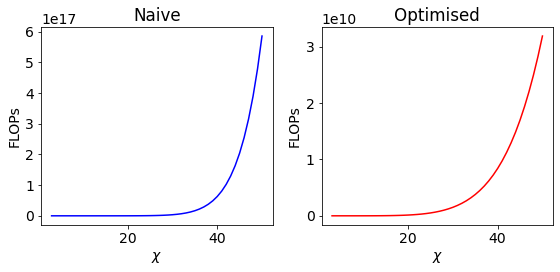

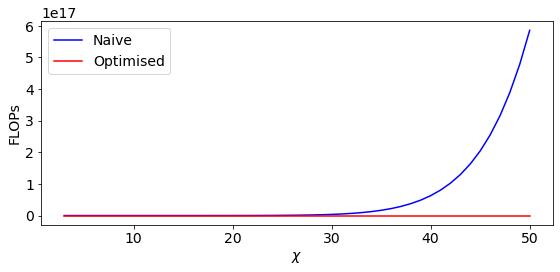

In [326]:
N, O = [], []
C = np.arange(3, 51)

for c in C:
    np.random.seed(42)
    lambda1 = np.random.normal(size=(c, c))
    lambda2 = np.random.normal(size=(c, c))
    lambda3 = np.random.normal(size=(c, c))
    G1 = np.random.normal(size=(c, c, c))
    G2 = np.random.normal(size=(c, c, c))
    U = np.random.normal(size=(c, c, c, c))
    
    res = np.einsum_path("ab,cbd,de,feg,gh,ijcf->ahij", lambda1, G1, lambda2, G2, lambda3, U, optimize=True)
    n, o = res[1].split('\n')[3:5]
    n = np.float64(n.split(' ')[-1])
    o = np.float64(o.split(' ')[-1])
    N.append(n)
    O.append(o)

    
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,4))

plt.subplot(121)
plt.plot(C, N, color="blue")
plt.title("Naive")
plt.xlabel("$\chi$")
plt.ylabel("FLOPs")

plt.subplot(122)
plt.plot(C, O, color="red")
plt.title("Optimised")
plt.xlabel("$\chi$")
plt.ylabel("FLOPs")

plt.tight_layout()

plt.figure(figsize=(8,4))
plt.plot(C, N, color="blue", label="Naive")
plt.plot(C, O, color="red", label="Optimised")
plt.xlabel("$\chi$")
plt.ylabel("FLOPs")

plt.legend()

plt.tight_layout()

In [179]:
c=2
np.random.seed(42)
lambda1 = np.random.normal(size=(c, c))
lambda2 = np.random.normal(size=(c, c))
lambda3 = np.random.normal(size=(c, c))
G1 = np.random.normal(size=(c, c, c))
G2 = np.random.normal(size=(c, c, c))
U = np.random.normal(size=(c, c, c, c))

In [180]:
lambda1
G1

array([[[ 0.24196227, -1.91328024],
        [-1.72491783, -0.56228753]],

       [[-1.01283112,  0.31424733],
        [-0.90802408, -1.4123037 ]]])

In [319]:
def mY_Z(lambda1, lambda2, lambda3, G1, G2, U):
    c=2
    A = np.tensordot(lambda1,G1, axes=([1], [1]))
    B = np.tensordot(lambda2, G2, axes=([1],[1]))
    C = np.tensordot(B, lambda3, axes=([2], [0]))
    D = np.tensordot(A, C, axes=([2], [0]))
    Z = np.tensordot(D, U, axes=([1, 2], [2,3]))
    
    return Z

In [365]:
assert np.allclose(mY_Z(lambda1, lambda2, lambda3, G1, G2, U), Z(lambda1, lambda2, lambda3, G1, G2, U))

In [366]:
O, my, Oerr, myerr = [], [], [], []
C = np.arange(3, 50)

for c in C:
    np.random.seed(42)
    lambda1 = np.random.normal(size=(c, c))
    lambda2 = np.random.normal(size=(c, c))
    lambda3 = np.random.normal(size=(c, c))
    G1 = np.random.normal(size=(c, c, c))
    G2 = np.random.normal(size=(c, c, c))
    U = np.random.normal(size=(c, c, c, c))
    

    time1 = %timeit -o -q -n 2 -r 2 mY_Z(lambda1, lambda2, lambda3, G1, G2, U)
    time2 = %timeit -o -q -n 2 -r 2 Z(lambda1, lambda2, lambda3, G1, G2, U)
    
    my.append(time1.average)
    myerr.append(3*time1.stdev)
    O.append(3*time2.average)
    Oerr.append(time2.stdev)

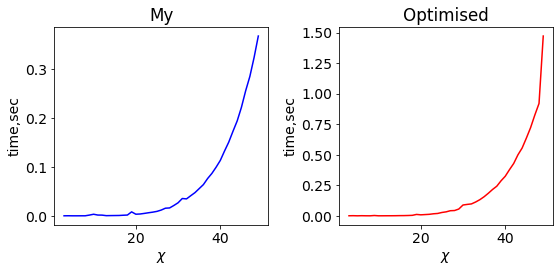

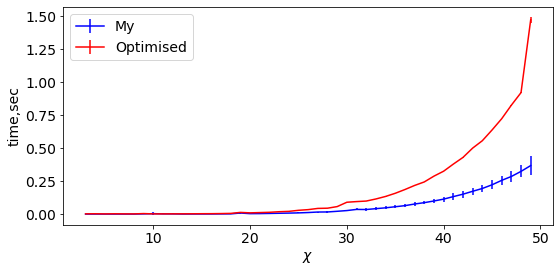

In [367]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,4))

plt.subplot(121)
plt.plot(C, my, color="blue")
plt.title("My")
plt.xlabel("$\chi$")
plt.ylabel("time,sec")

plt.subplot(122)
plt.plot(C, O, color="red")
plt.title("Optimised")
plt.xlabel("$\chi$")
plt.ylabel("time,sec")

plt.tight_layout()

plt.figure(figsize=(8,4))
plt.errorbar(C, my, myerr, color="blue", label="My")
plt.errorbar(C, O, Oerr, color="red", label="Optimised")
plt.xlabel("$\chi$")
plt.ylabel("time,sec")

plt.legend()

plt.tight_layout()

### Задача 7

In [64]:
N = 1000
K = 3
d = 3
L = 10

np.random.seed(42)
mu_true = np.random.uniform(-L, L, size = (K, d))
data = np.random.normal(mu_true, size = (N, K, d))
data = np.vstack(data)
np.random.shuffle(data)

In [65]:
def scatter_plot(data, col=None):
    from mpl_toolkits.mplot3d import Axes3D 
    %matplotlib inline
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], s = 0.5, color=col)
    plt.show()

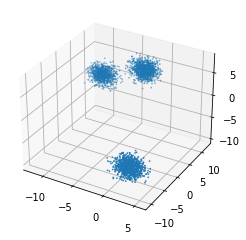

In [66]:
if d == 3:
    scatter_plot(data, None)

In [67]:
def naive_dist_i(x, mu):
    # x: N datapoints, mu: N cluster centers
    # returns: D_{i}, squared distances from x[i] to mu[i]
    dist = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        dist[i] = np.sum((x[i] - mu[i])**2)
    return dist

def naive_dist_ij(x, mu):
    # x: N datapoints, mu: K cluster centers
    # returns: D_{ij}, squared distances from x[i] to mu[j]
    dist = np.zeros((x.shape[0], mu.shape[0]))
    for i in range(x.shape[0]):
        for j in range(mu.shape[0]):
            dist[i, j] += np.sum((x[i] - mu[j])**2)
    return dist

def naive_kmeans():
    ss_list=[]
    mu = data[np.random.choice(range(data.shape[0]), K, replace=False)]
    c = np.random.randint(low=0, high=K-1, size=data.shape[0])
    for n in range(10):
        c =  np.argmin(naive_dist_ij(data, mu), axis = 1)    
        ss = np.mean(naive_dist_i(data, mu[c]))
        ss_list.append(ss)    
        for i in range(K):
            cluster_members = data[c == i]
            cluster_members = cluster_members.mean(axis = 0)
            mu[i] = cluster_members
    return ss_list, c

In [79]:
def dist_i(x, mu):
    # x: N datapoints, mu: N cluster centers
    # returns: D_{i}, squared distances from x[i] to mu[i]
    return np.sum((x - mu)**2)

def dist_ij(x, mu):
    # x: N datapoints, mu: K cluster centers
    # returns: D_{ij}, squared distances from x[i] to mu[j]
    n, k = x.shape
    x_mod = np.transpose(x[None,...].repeat(k, axis=0), axes=(1, 0, 2))
    mu_mod = mu[None, ...]
    return np.sum((x_mod-mu_mod)*(x_mod-mu_mod), axis=2)
   
def kmeans():
    ss_list=[]
    mu = data[np.random.choice(range(data.shape[0]), K, replace=False)]
    c = np.random.randint(low=0, high=K-1, size=data.shape[0])
    
    for _ in range(10):
        c =  np.argmin(dist_ij(data, mu), axis = 1)    
        ss = np.mean(dist_i(data, mu[c]))
        ss_list.append(ss)    
        for i in range(K):
            mu[i] = data[c==i].mean(axis=0)
    return ss_list, c

In [82]:
%timeit naive_kmeans()
%timeit kmeans()

885 ms ± 51.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/var/folders/h9/ll8t8frd1r575llt96l1glhm0000gn/T/ipykernel_21445/3230926319.py:24: RuntimeWarning: Mean of empty slice.
  mu[i] = data[c==i].mean(axis=0)
/Users/goloshch/.conda/envs/NPM/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


7.57 ms ± 419 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


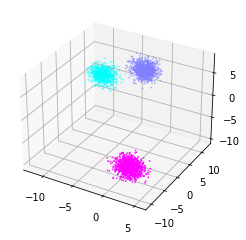

In [83]:
ss_list, c = kmeans()
plt.plot(ss_list)

colors = np.array([plt.cm.cool(i/(K-1)) for i in range(K)])
if d == 3:
    scatter_plot(data, colors[c])

__Вывод:__

- При N=1000 naive_kmeans работает за 874 ms ± 77.6 ms ms, kmeans за 7.7 ms ± 265 µs, т.е. быстрее примерно в 100 раз

- naive_kmeans для N=10000 мой компухтер уже не вывозит

### Задача 8

In [69]:
def HWseq1(n):
    if n > 2:
        a = np.zeros(n+1, dtype=int)
        a[1] = a[2] = 1
        for i in range(3, n+1):
            a[i] = a[a[i-1]] + a[i-a[i-1]]     
    else:
        a = np.array([0, 1, 1])[1:n+1]
        
    return a[1:]


def HWseq2(n):
    if n > 2:
        a = [0, 1, 1]
        a[1] = a[2] = 1
        for i in range(3, n+1):
            a.append(a[a[i-1]] + a[i-a[i-1]])
    else:
        a = [0, 1, 1][1:n+1]
 
    return np.array(a[1:])


@jit(nopython=True)
def HWseq3(n):
    if n > 2:
        a = np.zeros(n+1, dtype=np.int32)
        a[1] = a[2] = 1
        for i in range(3, n+1):
            a[i] = a[a[i-1]] + a[i-a[i-1]]     
    else:
        a = np.array([0, 1, 1], dtype=np.int32)[1:n+1]
        
    return a[1:]

In [70]:
n = 10**5

%timeit HWseq1(n)
%timeit HWseq2(n)
%timeit HWseq3(n)

79 ms ± 2.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
32.8 ms ± 258 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
520 µs ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


686 ms ± 21.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
52736107


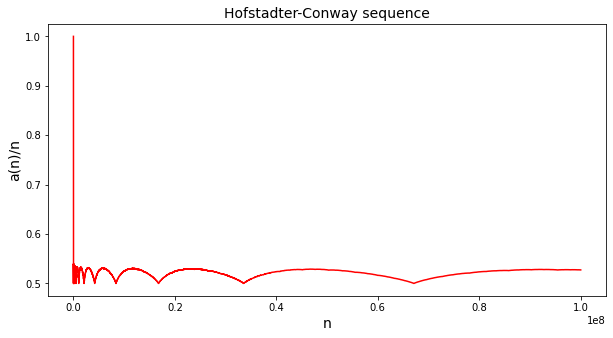

In [73]:
n=10**8

x = np.arange(1, n+1)
%timeit y = HWseq3(n)

plt.figure(figsize=(10,5))
plt.plot(x, y/x, color="red")
plt.ylabel("a(n)/n", fontsize=fontsize)
plt.xlabel("n", fontsize=fontsize)
plt.title("Hofstadter-Conway sequence", fontsize=fontsize)

print(y[-1])

__Вывод:__

- $a(10^8) = 52736107$
- $jit$-версия работает лучше всего